**Step 1**: Load dataset

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit
from maatpy.dataset import Dataset
seed = 0
yeast = Dataset()
yeast.load_from_csv('datasets/yeast_data.csv', output_column='Class', ignore='Sequence Name')
X = yeast.data
y = yeast.target
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed)
sss.get_n_splits(X, y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
yeast

{'data': array([[0.58, 0.61, 0.47, ..., 0.  , 0.48, 0.22],
        [0.43, 0.67, 0.48, ..., 0.  , 0.53, 0.22],
        [0.64, 0.62, 0.49, ..., 0.  , 0.53, 0.22],
        ...,
        [0.67, 0.57, 0.36, ..., 0.  , 0.56, 0.22],
        [0.43, 0.4 , 0.6 , ..., 0.  , 0.53, 0.39],
        [0.65, 0.54, 0.54, ..., 0.  , 0.53, 0.22]]),
 'target': array([6, 6, 6, ..., 4, 7, 0]),
 'feature_names': Index(['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc'], dtype='object'),
 'target_names': array(['CYT', 'ERL', 'EXC', 'ME1', 'ME2', 'ME3', 'MIT', 'NUC', 'POX',
        'VAC'], dtype='<U3')}

**Step 2**: Simulating dataset

In [13]:
from maatpy.dataset import simulate_dataset
from collections import Counter
sim_data = Dataset()
sim_data = simulate_dataset()
Xs = sim_data.data
Ys = sim_data.target
Counter(Ys)

Counter({1: 50, 0: 50})

**Step 3**: Make imbalance

In [18]:
sim_data.make_imbalance(ratio=[0.8, 0.2], random_state=seed)
Xi = sim_data.data
Yi = sim_data.target
Counter(Yi)

Counter({0: 80, 1: 20})

**Step 4**: Samplers, Pipeline and Plots

Class #1 has only 5 samples which when split into training and test set do not have enough samples to run the k-nearest neighbours algorithm for SMOTE even when k_neighbours are dropped to 3.
To avoid error the subsequent evaluations will use the following modified dataset which removes class 1.

In [43]:
X_mod= X[y!=1]
y_mod = y[y!=1]
print(X_mod.shape)
print(Counter(y_mod))
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed)
sss.get_n_splits(X_mod, y_mod)
for train_index, test_index in sss.split(X_mod, y_mod):
    Xm_train, Xm_test = X_mod[train_index], X_mod[test_index]
    ym_train, ym_test = y_mod[train_index], y_mod[test_index]

(1479, 8)
Counter({0: 463, 7: 429, 6: 244, 5: 163, 4: 51, 3: 44, 2: 35, 9: 30, 8: 20})


*plot_resampling*

[]

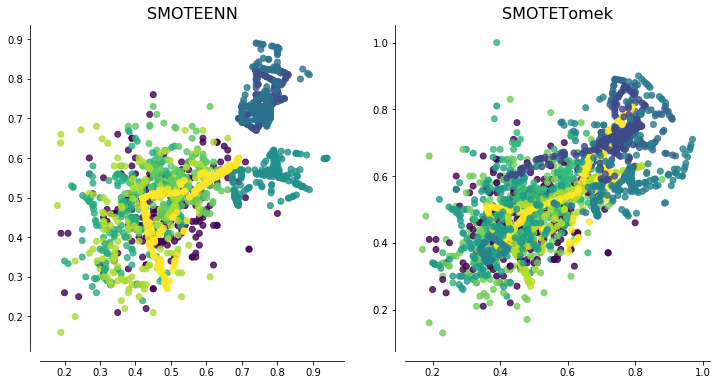

In [50]:
from maatpy.plots import plot_resampling
from maatpy.samplers import SMOTEENN, SMOTETomek
import matplotlib.pyplot as plt
from sklearn.svm import SVC

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax_arr = (ax1, ax2)

for ax, sampler in zip(ax_arr, [SMOTEENN(random_state=seed), SMOTETomek(random_state=seed)]):
    plot_resampling(Xm_train, ym_train, sampler, ax)
    ax.set_title('{}'.format(
        sampler.__class__.__name__), fontsize=16)
plt.plot()   

*plot_decision_function*

[]

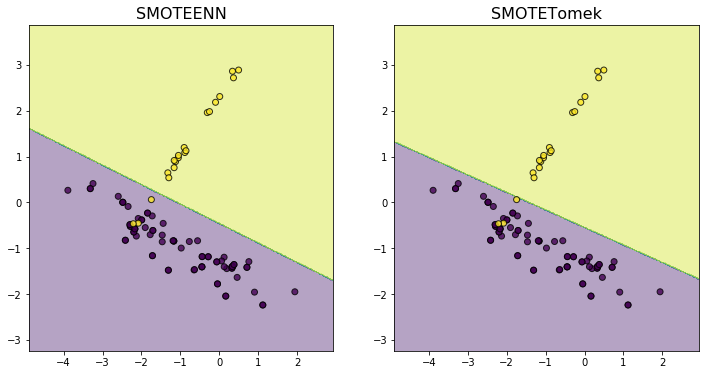

In [70]:
from maatpy.pipeline import make_pipeline
from maatpy.plots import plot_decision_function
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax_arr = (ax1, ax2)

#plot decision function only works for 2-features datasets
for ax, sampler in zip(ax_arr, [SMOTEENN(random_state=seed), SMOTETomek(random_state=seed)]):
    clf = make_pipeline(sampler, SVC(kernel="linear", random_state=seed))
    clf.fit(Xi, Yi)
    plot_decision_function(Xi, Yi, clf, ax)
    ax.set_title('{}'.format(
        sampler.__class__.__name__), fontsize=16)
plt.plot()

*plot_confusion_matrix*

Confusion matrix, without normalization
[[104   1   1   4   1  10  18   0   0]
 [  1  10   0   0   0   0   0   0   0]
 [  0   2  11   0   0   0   0   0   0]
 [  3   4   2   4   1   1   0   0   0]
 [  5   0   3   3  36   1   1   0   0]
 [ 15   2   1   7   1  44   2   1   0]
 [ 59   0   0   1   6   9  54   0   0]
 [  2   1   0   0   0   0   0   3   0]
 [  4   0   1   1   3   0   0   0   0]]


[]

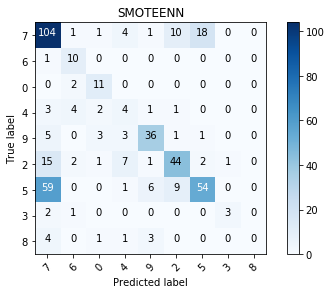

In [81]:
from maatpy.plots import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


sampler = SMOTEENN(random_state=seed)
clf = make_pipeline(sampler, SVC(kernel="linear", random_state=seed))
clf.fit(Xm_train, ym_train)
y_pred = clf.predict(Xm_test)
conf_matrix = confusion_matrix(ym_test,y_pred)
plot_confusion_matrix(conf_matrix, classes=Counter(ym_test).keys(), title='{}'.format(
    sampler.__class__.__name__))
plt.plot()


Confusion matrix, without normalization
[[93  2  0  1  1 12 11  0 19]
 [ 1 10  0  0  0  0  0  0  0]
 [ 0  2 10  1  0  0  0  0  0]
 [ 1  4  2  4  1  0  0  1  2]
 [ 4  0  1  3 38  0  0  0  3]
 [14  2  2  5  1 44  0  1  4]
 [55  2  0  0  7 11 48  0  6]
 [ 2  1  0  0  0  0  0  3  0]
 [ 3  0  0  1  3  0  0  0  2]]


[]

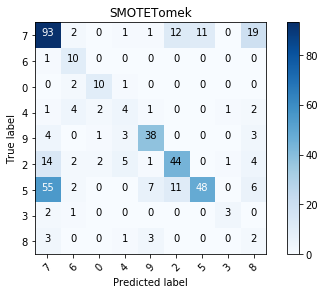

In [82]:
sampler = SMOTETomek(random_state=seed)
clf = make_pipeline(sampler, SVC(kernel="linear", random_state=seed))
clf.fit(Xm_train, ym_train)
y_pred = clf.predict(Xm_test)
conf_matrix = confusion_matrix(ym_test,y_pred)
plot_confusion_matrix(conf_matrix, classes=Counter(ym_test).keys(), title='{}'.format(
    sampler.__class__.__name__))
plt.plot()


**Step 5**: Classifiers

In [89]:
from maatpy.classifiers import AdaCost
from sklearn.metrics import cohen_kappa_score
import pandas as pd

results = {}
algorithm = ['adacost', 'adac1', 'adac2', 'adac3']
for alg in algorithm:
    clf = AdaCost(algorithm=alg, random_state=seed)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    kappa = cohen_kappa_score(y_test, y_pred)
    results[alg] = kappa
df1 = pd.DataFrame.from_dict(results, orient='index')
df1.columns = ['yeast']
df1

/Users/georgiakapatai/Dropbox/Courses/MScBirkbeck/FinalProject/Project/MaatPy/venv/lib/python3.7/site-packages/MaatPy-1.0-py3.7.egg/maatpy/classifiers/adacost.py:241: RuntimeWarning: overflow encountered in exp
  ((sample_weight > 0) | (estimator_weight < 0)))
/Users/georgiakapatai/Dropbox/Courses/MScBirkbeck/FinalProject/Project/MaatPy/venv/lib/python3.7/site-packages/MaatPy-1.0-py3.7.egg/maatpy/classifiers/adacost.py:241: RuntimeWarning: overflow encountered in multiply
  ((sample_weight > 0) | (estimator_weight < 0)))
/Users/georgiakapatai/Dropbox/Courses/MScBirkbeck/FinalProject/Project/MaatPy/venv/lib/python3.7/site-packages/sklearn/tree/tree.py:276: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(sample_weight))
/Users/georgiakapatai/Dropbox/Courses/MScBirkbeck/FinalProject/Project/MaatPy/venv/lib/python3.7/site-packages/numpy/lib/function_base.py:388: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(ax

,yeast
adacost,0.004627
adac1,0.000000
adac2,0.004627
adac3,0.004627


In [91]:
from maatpy.classifiers import (BalancedRandomForestClassifier,
                                SMOTEBoost, 
                                SMOTEBagging)
results = {}
for clf in [BalancedRandomForestClassifier(random_state=seed), 
            SMOTEBoost(random_state=seed),
            SMOTEBagging(random_state=seed)]:
    clf.fit(Xm_train, ym_train)
    y_pred = clf.predict(Xm_test)
    kappa = cohen_kappa_score(ym_test, y_pred)
    results[clf.__class__.__name__] = kappa
df1 = pd.DataFrame.from_dict(results, orient='index')
df1.columns = ['yeast']
df1 


/Users/georgiakapatai/Dropbox/Courses/MScBirkbeck/FinalProject/Project/MaatPy/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,yeast
BalancedRandomForestClassifier,0.297455
SMOTEBoost,0.475467
SMOTEBagging,0.467382
